In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/")

In [ ]:
from gym.envs.toy_text import CliffWalkingEnv
import plotting

import gym
import math
import numpy as np
import random
import itertools
from collections import namedtuple, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 环境测试

In [ ]:
env = CliffWalkingEnv()

## Q Learning

In [ ]:
def mu_policy(Q, epsilon, nA):
    """
    这是一个随机的策略, 执行每一个action的概率都是相同的.
    """
    def policy_fn(observation):
        # 看到这个state之后, 采取不同action获得的累计奖励
        action_values = Q[observation]
        # 使用获得奖励最大的那个动作
        greedy_action = np.argmax(action_values)
        # 是的每个动作都有出现的可能性
        probabilities = np.ones(nA) /nA * epsilon
        # 最好的那个动作的概率会大一些
        probabilities[greedy_action] = probabilities[greedy_action] + (1 - epsilon)
        
        return probabilities

    return policy_fn

In [ ]:
def pi_policy(Q):
    """
    这是greedy policy, 每次选择最优的动作
    """
    def policy_fn(observation):
        action_values = Q[observation]
        best_action = np.argmax(action_values) # 选择最优的动作
        return np.eye(len(action_values))[best_action] # 返回的是两个动作出现的概率
        
    return policy_fn

In [ ]:
def qLearning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.2):
    # 环境中所有动作的数量
    nA = env.action_space.n

    # 初始化Q表
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes+1),
        episode_rewards=np.zeros(num_episodes+1)) 
    
    # 初始化police, 因为是off-policy, 所以有两个策略
    behaviour_policy = mu_policy(Q, epsilon, nA) # 这是我们实际执行action时候采取的策略, 这里使用随机游走
    policy = pi_policy(Q)

    for i_episode in range(1, num_episodes + 1):
        # 开始一轮游戏
        state = env.reset()        
        action = np.random.choice(nA, p=behaviour_policy(state)) # 从实际执行的policy, 选择action
        for t in itertools.count():
            next_state, reward, done, _ = env.step(action) # 执行action, 返回reward和下一步的状态
            next_action = np.random.choice(nA, p=behaviour_policy(next_state)) # 选择下一步的动作

            # 更新Q
            Q[state][action] = Q[state][action] + alpha*(reward + discount_factor*max(Q[next_state]) - Q[state][action])

            # 计算统计数据
            stats.episode_rewards[i_episode] += reward # 计算累计奖励
            stats.episode_lengths[i_episode] = t # 查看每一轮的时间

            if done:
                break
            
            if t > 500:
                break

            state = next_state
            action = next_action
        
        if i_episode % 100 == 0:
            # 打印
            print("\rEpisode {}/{}. | ".format(i_episode, num_episodes), end="")
    
    return Q, policy, stats

In [ ]:
Q, policy, stats = qLearning(env, num_episodes=500, discount_factor=0.9, alpha=0.3, epsilon=0.1)

Episode 500/500. | 

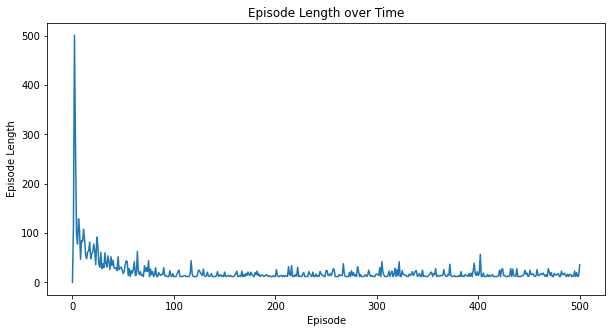

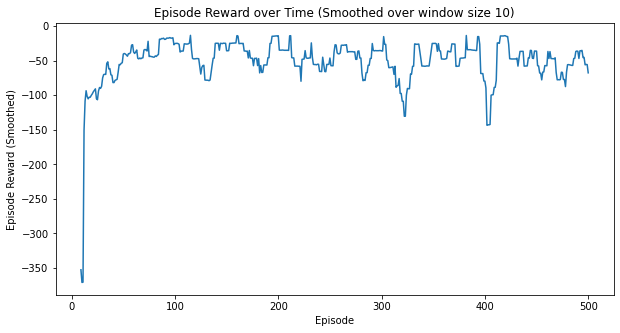

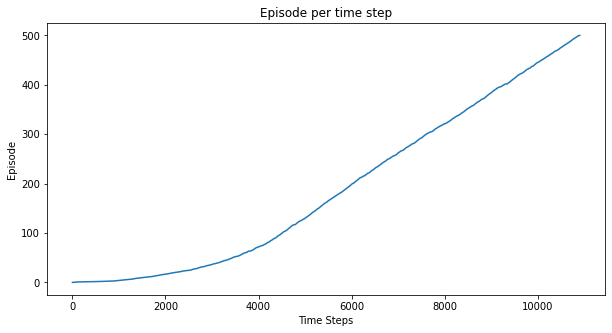

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
plotting.plot_episode_stats(stats)

## Deep Q Learning的实现

### Replay Memory

We’ll be using experience replay memory for training our DQN. 
It stores the transitions that the agent observes, allowing us to reuse this data later. 
By sampling from it randomly, the transitions that build up a batch are decorrelated (去相关). 
It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we're going to need two classses:

- **Transition** - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
- **ReplayMemory** - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [ ]:
Transition(24,1,25,1)

Transition(state=24, action=1, next_state=25, reward=1)

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity # 允许存储多少状态
        self.memory = [] # 存入的状态 
        self.position = 0 # memory的list的下标

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
test = ReplayMemory(5)
test.push(get_screen(1), 2.0, get_screen(3), 4.0)
test.push(get_screen(2), 6.0, get_screen(4), 8.0)
test.sample(2)

[Transition(state=tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), action=6.0, next_state=tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), reward=8.0),
 Transition(state=tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), action=2.0, next_state=tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), reward=4.0)]

### Input Extraction

这一部分是将环境返回的state, 转换为one-hot格式, 并作为网络的输入.

In [ ]:
def get_screen(state):
    """这里我们就用state来作为例子, 不直接使用截图了
    """
    y_state = torch.Tensor([[state]]).long()
    y_onehot = torch.FloatTensor(1, 48) # 产生位置

    # In your for loop
    y_onehot.zero_() # 全部使用0进行填充
    y_onehot.scatter_(1, y_state, 1) # 返回one-hot

    return y_onehot

In [ ]:
print(get_screen(1).shape)
get_screen(1)

torch.Size([1, 48])


tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Q Network的定义

Our model will be a linear network that takes in the one-hot code (这里网络的输入是将state转换为one-hot的编码). 

It has four outputs, representing Q(s,left), Q(s,right), Q(s,down), Q(s,up) (where s is the input to the network). 

In effect, the network is trying to predict the expected return of taking each action given the current input. (在当前输入下, 各个方向动作的概率值)

In [ ]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.l1 = nn.Linear(48, 24)
        self.l2 = nn.Linear(24, 12)
        self.l3 = nn.Linear(12, 4)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x # Returns tensor([[left0exp,right0exp,down0exp,down0exp]...]).

In [ ]:
model = DQN()
model(get_screen(1)) # 返回的4个action的值的大小

tensor([[-0.0524,  0.0964,  0.1775,  0.1297]], grad_fn=<AddmmBackward>)

### 选择动作函数

In [ ]:
def select_action(state, model, nA):
    """这里是包含探索的
    """
    global steps_done
    EPS_START = 0.9 # 初始的探索率
    EPS_END = 0.05 # 最终的探索了
    EPS_DECAY = 300 #进行200步骤, 到最终的探索率

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY) # 计算实时探索率
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return model(state).max(1)[1].view(1, 1) # 返回的最大动作的indice
    else:
        return torch.tensor([[random.randrange(nA)]], device=device, dtype=torch.long) # 随机选一个动作

In [ ]:
steps_done = 0
select_action(get_screen(1), model, 4).detach().item()

2

### 开始训练

In [ ]:
def QNetwork(env, num_episodes, policy_net, target_net, memory, discount_factor=1.0):
    TARGET_UPDATE = 10 # target网络的更新论数
    BATCH_SIZE = 256
    # 环境中所有动作的数量
    nA = env.action_space.n # 环境的动作个数
    
    # 记录reward和总长度的变化
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes+1),
        episode_rewards=np.zeros(num_episodes+1)) 
    

    for i_episode in range(1, num_episodes+1):
        # 开始一轮游戏
        state = env.reset()
        state=get_screen(state) # 将state转换为oen-hot的tensor, 用作网络的输入.
        action = select_action(state, model=policy_net, nA=nA)
        for t in itertools.count():
            next_state, reward, done, _ = env.step(action.detach().item()) # 执行action, 返回reward和下一步的状态
            if done:
                reward = 100
            reward = torch.tensor([reward], device=device) # 转为tensor
            next_state_tensor = get_screen(next_state) # 转为tensor
            next_action = select_action(state=next_state_tensor, model=policy_net, nA=nA) # 选择下一步的动作

            # 计算统计数据(带有探索的策略)
            stats.episode_rewards[i_episode] += reward # 计算累计奖励
            stats.episode_lengths[i_episode] = t # 查看每一轮的时间

            if done:
                next_state_tensor = None
                # 这里不能直接break, 需要进行push和状态更新
            else:
                pass

            # 将信息存入memory
            memory.push(state, action, next_state_tensor, reward)

            # 状态更新
            state = next_state_tensor
            action = next_action

            # 模型更新
            if len(memory) > BATCH_SIZE: # 首先确保memory里足够sample
                transitions = memory.sample(BATCH_SIZE)
                batch = Transition(*zip(*transitions)) # 转换为如下效果, Transition(state=(5, 1), action=(6, 2), next_state=(7, 3), reward=(8, 4))
                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool) # 确认哪些不是终点
                non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]) # 将不是None的next_state连起来

                # 下面是将几个变量都转换为batch的类型
                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.cat(batch.reward)

                state_action_values = policy_net(state_batch).gather(1, action_batch) # Q(s,a)的值

                next_state_values = torch.zeros(BATCH_SIZE, device=device)
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
                
                # Compute the expected Q values
                expected_state_action_values = (next_state_values * discount_factor) + reward_batch

                # Compute Huber loss
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                # for param in policy_net.parameters():
                #     param.grad.data.clamp_(-1, 1)
                optimizer.step()

            if done:
                break
            if t > 500:
                break

        if i_episode % TARGET_UPDATE == 0:
            # target net更新参数
            target_net.load_state_dict(policy_net.state_dict())
        
        if i_episode % 50 == 0:
            print("\rEpisode {}/{}. | ".format(i_episode, num_episodes), end="")

    return stats

### 开始运行

In [ ]:
env = CliffWalkingEnv() # 初始化环境

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), 0.002)
memory = ReplayMemory(500)

steps_done = 0

stats = QNetwork(env, 2000, policy_net, target_net, memory, discount_factor=0.9)

Episode 2000/2000. | 

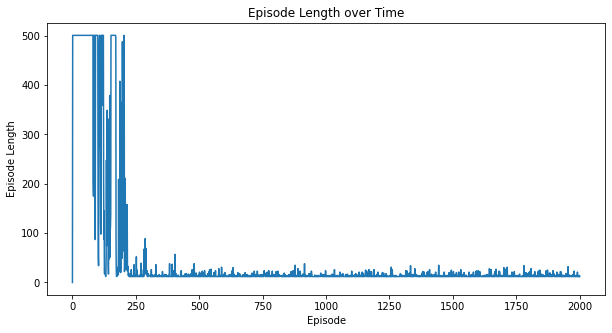

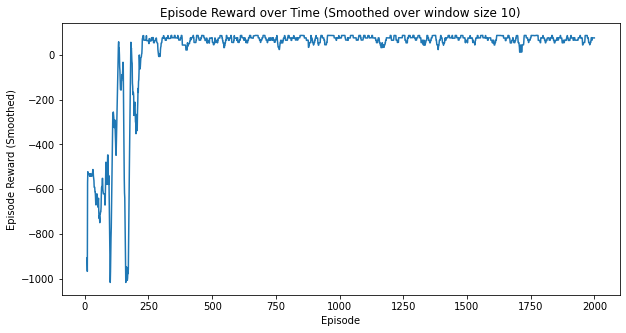

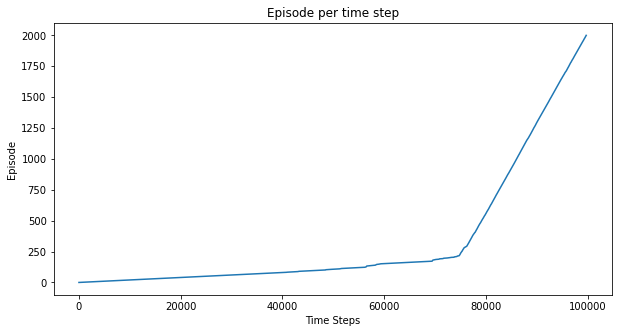

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
plotting.plot_episode_stats(stats)

### 单步测试

In [ ]:
transitions = memory.sample(5)
batch = Transition(*zip(*transitions)) # 转换为如下效果, Transition(state=(5, 1), action=(6, 2), next_state=(7, 3), reward=(8, 4))
batch

Transition(state=(tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 

In [ ]:
non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool) # 确认哪些不是终点
non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]) # 将不是None的next_state连起来

state_batch = torch.cat(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.cat(batch.reward)

In [ ]:
action_batch

tensor([[0],
        [2],
        [2],
        [1],
        [3]])

In [ ]:
reward_batch

tensor([-1, -1, -1, -1, -1])

In [ ]:
state_action_values = policy_net(state_batch).gather(1, action_batch) # Q(s,a)的值

next_state_values = torch.zeros(5, device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

# Compute the expected Q values
expected_state_action_values = (next_state_values * 0.9) + reward_batch

In [ ]:
state_action_values

tensor([[11.1293],
        [17.8900],
        [17.8900],
        [21.9252],
        [17.7576]], grad_fn=<GatherBackward>)

In [ ]:
next_state_values

tensor([21.1504, 21.0128, 21.0128, 21.1504, 21.0128])

In [ ]:
expected_state_action_values

tensor([-9.0301, -8.9794, -8.9794, -9.0301, -8.9794])

In [ ]:
expected_state_action_values.unsqueeze(1)

tensor([[-9.0301],
        [-8.9794],
        [-8.9794],
        [-9.0301],
        [-8.9794]])

In [ ]:
F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

tensor(0.0020, grad_fn=<SmoothL1LossBackward>)

In [ ]:
F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

tensor(0.0020, grad_fn=<SmoothL1LossBackward>)